## Importing all libraries

In [1]:
import os
os.environ['MUJOCO_GL'] = 'glfw'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import mujoco

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite


%load_ext autoreload

Checking that the dm_control installation succeeded...


In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco as dm_mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.core import MjvOption
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf
from dm_control import viewer

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite


# Manipulation
from dm_control import manipulation

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import IPython.display as display
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# # Inline video helper function
# if os.environ.get('COLAB_NOTEBOOK_TEST', False):
#   # We skip video generation during tests, as it is quite expensive.
#   display_video = lambda *args, **kwargs: None
# else:

# from PIL import Image, ImageSequence
from IPython.display import Video
def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  display.display(HTML(anim.to_html5_video()))
# import imageio
# def display_video(frames, framerate=30):
#     # Create a writer object
#     writer = imageio.get_writer('output.mp4', fps=framerate)

#     # Write frames to the writer
#     for frame in frames:
#         writer.append_data(frame)

#     # Close the writer
#     writer.close()    

    # # Convert the frames to PIL images
    # images = [Image.fromarray(frame) for frame in frames]

    # images[0].save('task.gif', save_all=True, append_images=images[1:], loop=0, duration=1000/framerate)

    # # Display the GIF animation
    # # with open('animation.gif','rb') as f:
    # #     display.display(display.Image(data=f.read(), format='png'))
    # return Video('task.gif')

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

Import the robot assets needed for the task first

## Make Classes to store each Robot Model
Attach the Robot Model to the main model

In [3]:
from rocobench.envs.robot import SimRobot

from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS, PANDA_CONSTANTS, KINOVA_CONSTANTS

#Handle Configs to work with SimRobot and MultiArmRRT
def append_robot_names(name, constants):
    result = dict()
    result["name"] = name
    for key, value in constants.items():
        #print(key)
        if key=='name':
            continue

        if key == "actuator_info":
            result[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif key == "mesh_to_geoms":
            result[key] = {x: [name + "/" + y for y in z] for x, z in value.items()}

        elif isinstance(constants[key],str):
            result[key]= name+'/'+value
        else:
            result[key] = [name + "/" + x for x in value]

    return result

/home/adityadutt/miniconda3/envs/robot-collab/lib/python3.8/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/adityadutt/miniconda3/envs/robot-collab/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/adityadutt/miniconda3/envs/robot-collab/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/adityadutt/miniconda3/envs/robot-collab/lib/python3.8/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/home/adityadutt/miniconda3/envs/robot-collab/lib/python3.8/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two mino

In [4]:
robots = { "panda": {
                "robot_config": append_robot_names("panda", PANDA_CONSTANTS),
                "robot_type": "panda",
                "file": 'rocobench/envs/assets/panda/panda.xml',
                "worldbody_site_pos": [0.4, -.15, 0.1]
            
            },
            "ur5e":{
                "robot_config": append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS),
                "robot_type": "ur5e",
                "file": 'rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml',
                "worldbody_site_pos": [0.2, 1.2, 0.1]
            }
        }

# Defining the Task

In [5]:
from copy import deepcopy

TASK_OBJECTS = [["key_card", "right_door_handle", "table_top"]]

class DoorCabinet():
    def __init__(self, filepath = None, **kwargs):
        
        # super(DoorCabinet, self).__init__(filepath, 
        #                                   task_objects=TASK_OBJECTS, 
        #                                   **kwargs
        #                                 )
        
        self.model = mjcf.RootElement(model="doorcabinet")

        #Set the global_params
        self.global_params()
        #Set default classes
        self.set_dclasses()
        #Build the scene
        self.build_scene()
        
        #Store Robot Configs
        self.robot_configs = {"panda": PANDA_CONSTANTS.copy(), "ur5e": UR5E_ROBOTIQ_CONSTANTS.copy(), 
                              "kinova": KINOVA_CONSTANTS.copy()}
    

        self.add_robots(kwargs["robots"])

        print("Add Robots Works!")

        #If add cameras:
        self.add_cameras()

        self.physics = mjcf.Physics.from_mjcf_model(self.model)

        #Create new config based on which robot it is
        #Dictionary storing the SimRobot instances of all robots
        self.sim_robots = {}

        # for robot_name, robot_data in kwargs["robots"].items():  
        #     new_config = append_robot_names(robot_name, self.robot_configs[robot_data["robot_type"]])

        #     #Create SimRobot instances
        #     self.sim_robots[robot_name] = SimRobot(physics=self.physics,use_ee_rest_quat=False, **new_config)  
        
        self.door_name = "cabinet/right_door_handle"
        self.cabinet_pos = self.physics.data.body("cabinet/cabinet").xpos.copy()
        self.open_door_pose = self.compute_door_open_pose() #[3, 4]

        # self.joint_ids = {#"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
        #      "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl},
        #      "ur5e": {"qpos":ur5e.joint_idxs_in_qpos, "ctrl":ur5e.joint_idxs_in_ctrl}
        #     }

        
    def global_params(self):
        #Compiler options
        self.model.compiler.angle = 'radian'
        self.model.compiler.autolimits = 'true'

        #Visual options
        self.model.visual.headlight.diffuse = [0.6, 0.6, 0.6] #Can use a list format or a string format
        self.model.visual.headlight.ambient=[0.1, 0.1, 0.1]
        self.model.visual.headlight.specular=[0, 0, 0]
        self.model.visual.rgba.haze = "0.15 0.25 0.35 1"
        self.model.visual.__getattr__('global').azimuth = 120 #Only way to access global attribute since gloabl is a Python keyword
        self.model.visual.__getattr__('global').elevation = -20
        self.model.visual.__getattr__('global').offwidth = 2000
        self.model.visual.__getattr__('global').offheight = 2000
        self.model.visual.quality.shadowsize = 4096

    def set_dclasses(self):
        #Default class values
        self.obj_visual_class = self.model.default.add('default', dclass="object_visual")
        self.obj_site_class = self.model.default.add('default', dclass='object_sites')
        self.obj_collision_class = self.model.default.add('default', dclass='object_collision')
        # obj_hingecabinet = self.model.default.add('default', dclass="hingecabinet")

        self.obj_visual_class.geom.type = 'mesh'
        self.obj_visual_class.geom.conaffinity = '0'
        self.obj_visual_class.geom.contype = '0'
        self.obj_visual_class.geom.group = '1'
        self.obj_visual_class.geom.mass = '0.00001'

        #add('site', type='cylinder', size='0.003 0.006', group=3)
        self.obj_site_class.site.type = 'cylinder'
        self.obj_site_class.site.size = '0.003 0.006'
        self.obj_site_class.site.group = 3           

        # <geom density="500" rgba="0.8 0.8 0.8 0.9" group="3"/>
        self.obj_collision_class.geom.density = '500'
        self.obj_collision_class.geom.rgba = '0.8 0.8 0.8 0.9'
        self.obj_collision_class.geom.group = 3

    def build_scene(self):
        #Floor and initial light
        self.model.worldbody.add('light', pos="0 0 1.5", dir="0 0 -1", directional="true")

        self.groundplane_texture = self.model.asset.add('texture', type="2d", name="groundplane", builtin="checker", mark="edge", rgb1="0.2 0.3 0.4", rgb2="0.1 0.2 0.3", markrgb="0.8 0.8 0.8", width="300", height="300")
        self.groundplane_mat = self.model.asset.add('material', name="groundplane", texture="groundplane", texuniform="true", texrepeat="2 2", reflectance="0.2")
        self.groundplane = self.model.worldbody.add('geom', name="floor", pos="0 0 -0.5", size="0 0 0.05", type="plane", material="groundplane")

        #Adding the table box
        self.table_box = self.model.worldbody.add('body', name="table", pos="0 0.5 0")
        self.table_box.add('geom', name="table_collision", pos="0 0 0.1", size="1.6 .5 0.05", type="box") #friction="1 0.005 0.0001")
        # self.table_box.add('geom', material="white-wood", name="table-mat")

        self.table_top = self.table_box.add('body', name="table_top", pos="0 0 0.11")
        self.table_top.add('geom', name="table_top", size="1.6 0.4 0.05", type="box", conaffinity="0", contype="0", group="1")
        # table_top.add('site', name="table_top", size="0.001 0.001 0.001", class_="site_top")

        self.table_box.add('geom', name="table_left", pos="-1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_right", pos="1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_front", pos="0 1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_back", pos="0 -1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box");

        #Adding a key card on the table
        self.key_card = self.model.worldbody.add('body', name="keycard", pos="0.5 0.6 0.1")

        #Can also do add_free_joint()
        self.key_card.add('freejoint', name="keycard_joint") #, type="free", name="keycard_joint", pos="0 0 0", axis="0 0 1")
        self.key_card.add('geom', name='keycard', type="box", rgba="0. 0. 0. 1", size="0.05 0.1 0.01")

        #Add the cabinet    
        self.cabinet_path = "rocobench/envs/assets/cabinet/cabinet_mjcf.xml"
        self.cabinet =  mjcf.from_file(self.cabinet_path)
        self.cabinet.model = "cabinet"
        self.model.attach(self.cabinet)

        #Add the camera
        self.camera = self.model.worldbody.add('camera', name='my_camera', pos="2.1 -0.15 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def add_cameras(self):
        self.model.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
        self.model.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
        self.model.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
        self.model.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
        self.model.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
        self.model.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
        self.model.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def render_scene(self, ctrl: dict, duration, framerate, cam: int, width=800, height=800):
        # Simulate and display video.
        frames = []
        self.physics.reset()  # Reset to keyframe 0 (load a saved state).
        while self.physics.data.time < duration:
            self.physics.data.ctrl[ctrl["ctrl_idxs"]] = ctrl["ctrl_vals"]
            self.physics.step()
            if len(frames) < (self.physics.data.time) * framerate:
                pixels = self.physics.render(camera_id=cam, width=width, height=height)
                frames.append(pixels)

        display_video(frames, framerate)

    def render_image(self, cam_id:int, qpos = None, qpos_id = None, width=1080, height=800):
        if qpos == None:
            self.physics.reset()
            img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        else:
            with self.physics.reset_context():
                self.physics.data.qpos[qpos_id] = qpos
                self.physics.step()

                img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        return img

    def add_robots(self, robot_dict):
        #Generalize for multiple robots/arms
        self.robot_models = {}


        for robot_name, robot_data in robot_dict.items():   
            
            #Create robot model to attach to mujoco world model
            robot = mjcf.from_path(robot_data["file"])
            robot.model = robot_name
            robot_site = self.model.worldbody.add('site', name=robot_name, pos=robot_data["worldbody_site_pos"], size=[0.001, 0.001, 0.001])
            robot_site.attach(robot)
            self.robot_models[robot_name] = deepcopy(robot)
            del robot, robot_site
        
        # self.panda_arm1 = Panda("panda1", arm_pos=[0.6, 1.02, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm2 = Panda("panda2", arm_pos=[0.6, -0.05, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        
        # self.panda_arm1 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm1.model = "panda1"
        # self.ur5e = mjcf.from_path('rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
        # self.ur5e.model = "ur5e"
        
        # ur5e_site = self.model.worldbody.add('site', name='ur5e', pos=[0.2, 1.2, 0.1], size=[0.001, 0.001, 0.001])
        # ur5e_site.attach(self.ur5e)

        # self.panda_arm2 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm2.model = "panda2"    
        
        # # panda_arm1_site = self.model.worldbody.add('site', name='panda1', pos=[0.2, 1.15, 0.1], size=[0.001, 0.001, 0.001])
        # # panda_arm1_site.attach(self.panda_arm1)

        # panda_arm2_site = self.model.worldbody.add('site', name='panda2', pos=[0.4, -.15, 0.1], size=[0.001, 0.001, 0.001])
        # panda_arm2_site.attach(self.panda_arm2)

        ## Add Kinova Arm 
        # self.kinovagen3_arm = mjcf.from_path("rocobench/envs/assets/kinova_with_base/base_with_kinova_gripper.xml")
        # self.kinovagen3_arm.model = "kinovagen3"
        # kinovagen3_site = self.model.worldbody.add('site', name="kinovagen3", pos= [1.3, -0.15, -0.5], size=[0.001, 0.001, 0.001])
        # kinovagen3_site.attach(self.kinovagen3_arm)

        #Add weld connections -> Add Adhesion instead
        self.model.equality.add("weld", name="door_handle_panda", body1="cabinet/right_door_handle", body2="ur5e/robotiq_tip", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
        self.model.equality.add("weld", name="keycard_panda", body1="keycard", body2="panda/panda_palm", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
     
    def compute_door_open_pose(self, door_name: str = "cabinet/right_door_handle"):
        physics = self.physics.copy(share_model=True)
        # if door_name == "left_door_handle":p
        #     qpos_slice = self.physics.named.data.qpos._convert_key("leftdoorhinge")
        #     if self.cabinet_pos[0] > 0:
        #         physics.data.qpos[qpos_slice.start] = -2.2
        #     else:
        #         physics.data.qpos[qpos_slice.start] = -2.6
        # elif door_name == "right_door_handle":
        qpos_slice = self.physics.named.data.qpos._convert_key("cabinet/rightdoorhinge")
        if self.cabinet_pos[0] > 0:
            physics.data.qpos[qpos_slice.start] = 1.8    
        else:
            physics.data.qpos[qpos_slice.start] = 1.
        # else:
        #     raise NotImplementedError
        physics.forward()
        desired_handle_pose = np.concatenate(
            [physics.data.body(door_name).xpos, physics.data.body(door_name).xquat]
        ) 
        # img = physics.render(camera_id="teaser")
        # plt.imshow(img)
        # plt.show()
        del physics 
        return desired_handle_pose   

    # def visualize_traj(self,traj,):
    #     frames = []
    #     ctrls=[]
    #     duration=10
    #     framerate=30
    #     control_rate=0.005
    #     doorcabinet.physics.reset()  # Reset state and time

    #     #Reset to home pose for visualization
    #     reset_to_home_pose(doorcabinet.physics, joint_ids)
    #     doorcabinet.physics.named.model.eq_active["keycard_panda"] = False

    #     # doorcabinet.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255
    #     doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
    #     doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255


    #     # Simulate and display video.
    #     while doorcabinet.physics.data.time < duration:
    #         idx = int(doorcabinet.physics.data.time/ control_rate)

    #         if idx >= len(paths):
    #             idx = len(paths) - 1
            
    #         if idx >= key_grasp_idx:
    #             doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 0
    #             doorcabinet.physics.named.model.eq_active["keycard_panda"] = True


    #         if idx >= door_grasp_idx:
    #             doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 0
    #             doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True


    #         t0 = doorcabinet.physics.data.time
    #         # doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos] = paths[idx][:num_panda_joints]
    #         # panda1_ctrl_vals = doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos]
    #         # doorcabinet.physics.data.ctrl[panda1.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx]
    #         # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

    #         qpos = doorcabinet.physics.data.qpos.copy()
    #         qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = paths[idx]
    #         ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
    #         ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)

    #         doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]
    #         doorcabinet.physics.data.ctrl[ctrl2["ctrl_idxs"]] = ctrl2["ctrl_vals"]

    #         # doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = paths[idx][num_panda_joints:]
    #         # panda2_ctrl_vals = doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos]
    #         # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = paths[idx][num_panda_joints:]

    #         # ctrl=np.concatenate((ctrl1["ctrl_vals"],[0],panda2_ctrl_vals,[0]))
    #         # doorcabinet.physics.data.ctrl=ctrl
    #         while doorcabinet.physics.data.time-t0<control_rate:
    #             doorcabinet.physics.step()
    #             if len(frames) < doorcabinet.physics.data.time * framerate:
    #                 pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)#, scene_option=scene_option), render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False})
    #                 frames.append(pixels)

doorcabinet = DoorCabinet(robots = robots)

Add Robots Works!


In [9]:
# def get_geoms_by_group(physics, group_number):
#     geoms = []
#     for geom_id in range(physics.named.model.geom_id.n):
#         geom_attrs = physics.named.data.geom_xpos[geom_id]
#         geom_group = physics.model.geom_group[geom_id]
#         if geom_group == group_number:
#             geoms.append(geom_attrs)
#     return geoms

geom_idx = np.where(doorcabinet.physics.model.geom_group == 3)
print(geom_idx)
# doorcabinet.physics.named.data.geom_xpos[geom_idx]
# doorcabinet.physics.named.model.geom_size

(array([ 31,  33,  35,  40,  45,  49,  50,  51,  69,  78,  84,  87,  88,
        89,  90,  91,  92,  95,  96,  97,  98,  99, 100, 106, 111, 112,
       117, 118, 122, 126, 127, 129, 131, 133, 135, 137, 139, 141, 142,
       143, 147, 149, 151, 153, 154, 155]),)


In [10]:
# doorcabinet.physics.named.data.geom_xpos[geom_idx]
doorcabinet.physics.model.geom(133)

<_MjModelGeomViews
  bodyid: array([34], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([92], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([3], dtype=int32)
  id: 133
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'ur5e/base_collision'
  pos: array([ 9.19702617e-08, -2.70393921e-05,  3.54674813e-02])
  priority: array([0], dtype=int32)
  quat: array([ 9.99998832e-01, -1.52849468e-03,  1.94044105e-08,  1.26950968e-05])
  rbound: array([0.07864571])
  rgba: array([0.5, 0.5, 0.5, 1. ], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.03750009, 0.04242574, 0.05457973])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([7], dtype=int32)
  user: array([], dtype=float64)
>

In [8]:
doorcabinet.physics.named.data.qpos

FieldIndexer(qpos):
 0                   keycard_joint [ 0.5     ]
 1                   keycard_joint [ 0.6     ]
 2                   keycard_joint [ 0.1     ]
 3                   keycard_joint [ 1       ]
 4                   keycard_joint [ 0       ]
 5                   keycard_joint [ 0       ]
 6                   keycard_joint [ 0       ]
 7          cabinet/rightdoorhinge [ 0       ]
 8          panda/panda_base_joint [ 0       ]
 9                    panda/joint1 [ 0       ]
10                    panda/joint2 [ 0       ]
11                    panda/joint3 [ 0       ]
12                    panda/joint4 [ 0       ]
13                    panda/joint5 [ 0       ]
14                    panda/joint6 [ 0       ]
15                    panda/joint7 [ 0       ]
16             panda/finger_joint1 [ 0       ]
17             panda/finger_joint2 [ 0       ]
18          ur5e/ur5e_0_base_joint [ 0       ]
19  ur5e/ur5e_0_shoulder_pan_joint [ 0       ]
20 ur5e/ur5e_0_shoulder_lift_joint [ 0  

In [11]:
### Kinova Home Qpos:[0.01, 1.6014, -1.06811, 0.06283, -0.94245, 3.1415, 1.06811, 0.00705532]
# kinova_qpos = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]
# ur5e_qpos = [0., -1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]

# reset_qpos = ur5e_qpos + kinova_qpos
# qpos_ids = [i for i in range(8, 15)] + [j for j in range(33, 41)]

# print(reset_qpos, qpos_ids)

# doorcabinet.render_image(qpos = reset_qpos, qpos_id = qpos_ids, cam_id = 6)

In [12]:
# doorcabinet.physics.data.body("cabinet/cabinet").xpos

In [13]:
# from rocobench.envs.robot import SimRobot

# from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS, PANDA_CONSTANTS

# #Handle Configs to work with SimRobot and MultiArmRRT
# def append_robot_names(name,panda_constants):
#     constants = dict()
#     constants["name"] = name
#     for key, value in panda_constants.items():
#         #print(key)
#         if key=='name':
#             continue
#         if key == "actuator_info":
#             constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
#         elif isinstance(panda_constants[key],str):
#             constants[key]=name+'/'+value
#         else:
#             constants[key] = [name + "/" + x for x in value]

#     return constants

# # panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
# panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)
# ur5e_constants = append_robot_names("ur5e",UR5E_ROBOTIQ_CONSTANTS)
# # kinova_constants = append_robot_names("kinova",KINOVA_CONSTANTS)


# # panda1=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda1_constants)
# panda2=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda2_constants)
# ur5e = SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**ur5e_constants)
# # kinova = SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**kinova_constants)

# # robots={'panda1':panda1,'panda2':panda2}
# robots={'ur5e':ur5e,'panda2':panda2}

# ur5e.ik_joint_names, panda2.ik_joint_names

# Rendering the final environment

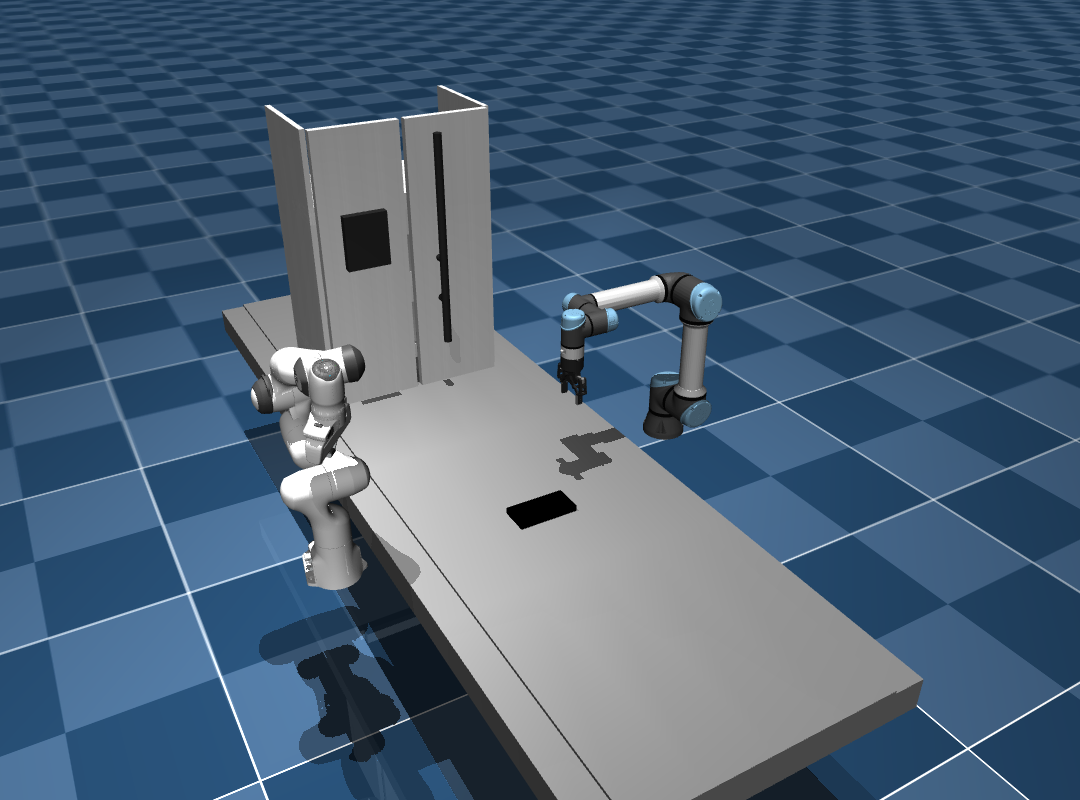

In [9]:
##UR5E RESET POS: qpos="-1.5708 -1.5708 1.5708 -1.5708 -1.5708 0"

##PANDA RESET POSE: qpos="0 0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"

def reset_to_home_pose(physics, joint_ids, render=False):
    physics.reset()
    # with doorcabinet.physics.reset_context():
    physics.named.model.eq_active["keycard_panda"] = False
    physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.17, 1., 0., 0., 0.]
    physics.named.model.eq_active["door_handle_panda"] = False
        # qpos="0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"
        # physics.data.qpos[joint_ids["panda1"]["qpos"] + joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
    physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.] # (9, 10, 11, 12, 13, 14, 8)
    physics.data.qpos[joint_ids["panda2"]["qpos"]] = [0., -1.3, 0., -2.5, 0, 1., 0., 0.]

    physics.data.ctrl = 0.

    ##Kinova home pos
    # physics.data.qpos[np.arange(33, 41)] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]

    # physics.data.ctrl = 0.
    physics.data.qvel = 0.
    physics.step()

    if render:
        img = PIL.Image.fromarray(physics.render(camera_id=6, width=1080, height=800))
        return img
    
    return None

joint_ids = {#"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
             "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl},
             "ur5e": {"qpos":ur5e.joint_idxs_in_qpos, "ctrl":ur5e.joint_idxs_in_ctrl}
            }

reset_to_home_pose(doorcabinet.physics, joint_ids, True)
# doorcabinet.physics.step()
# PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

In [113]:
ur5e.joint_idxs_in_qpos

[9, 10, 11, 12, 13, 14, 8]

## POLICY Section
Input a pair of target pose for both robot, then use the planner to generate motion traj. for both robots to reach the target pose

In [ ]:
# # # ## Move Stuff in Sim to test and work ##
# # # # doorcabinet.physics.named.data.qpos

# # #Define target poses and orientations
# keycard_pos = doorcabinet.physics.named.data.xpos["keycard"]
# keycard_quat = np.array([ 0., 1., 0., 0. ])

# doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"]
# doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])


# pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
#                     "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
#                 }

# doorhinge_result = ur5e.solve_ik(doorcabinet.physics, pre_grasp_poses["doorhinge"]["pos"], pre_grasp_poses["doorhinge"]["quat"])
# print(doorhinge_result)

# keycard_result = panda2.solve_ik(doorcabinet.physics, pre_grasp_poses["keycard"]["pos"], pre_grasp_poses["keycard"]["quat"])
# print(keycard_result)


## Implementing RRT 

In [ ]:
### Visualizing the data ###
%autoreload 2
from rocobench.rrt_multi_arm import MultiArmRRT

In [ ]:
doorcabinet.physics.named.data.xpos

In [ ]:
### create allowed_collision pairs: Cabinet IDs: (4 -> 10) UR5e IDs: (11 -> 34) Panda IDs: (35 -> 47)
allowed_collision_pairs = []
allowed_collision_pairs += [(1, 9), (1, 3), (1, 4), (1, 6)]
for i in range(4, 11):
    allowed_collision_pairs += [(j, i) for j in range(11, 35)] 
    allowed_collision_pairs += [(j, i) for j in range(35, 48)]

print(allowed_collision_pairs)

rrt = MultiArmRRT(doorcabinet.physics, 
                  robots,
                  allowed_collision_pairs=allowed_collision_pairs,
                  seed = 391)

#Ensuring No Initial Collisions
reset_to_home_pose(doorcabinet.physics, joint_ids, True)
start_qpos = doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()

print(rrt.check_collision(start_qpos, physics=doorcabinet.physics))


with doorcabinet.physics.reset_context():
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = start_qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width=1080, height=800))
img



In [ ]:
#Goal Pos: Keycard and DoorHinge
# p1_goal = rrt.solve_ik(doorcabinet.physics, 
#                        site_name=panda1.ee_site_name, 
#                        target_pos=doorhinge_pos + np.array([.2, 0., 0.1 ]), 
#                        target_quat=doorhinge_quat, 
#                        joint_names=panda1.ik_joint_names
#                     )

p1_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=ur5e.ee_site_name, 
                       target_pos=doorhinge_pos + np.array([.0, 0., 0.0 ]), 
                       target_quat=[0., 0.707, 0., 0.707], 
                       joint_names=ur5e.ik_joint_names
                    )

# print(doorhinge_pos+ + np.array([.2, 0., 0.1 ]))

p2_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos=keycard_pos + np.array([0.0, 0.0, 0.14]), 
                       target_quat=keycard_quat, 
                       joint_names=panda2.ik_joint_names
                    )

# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[ur5e.joint_idxs_in_qpos] = p1_goal.qpos[ur5e.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

#Second Path
keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"]
keyreader_pos += np.array([.3, 0.2, 0.2])
keyreader_quat = np.array([0., -0.707, 0., 0.707])

p2_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos= keyreader_pos, 
                       target_quat=keyreader_quat, 
                       joint_names=panda2.ik_joint_names
                    )


# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[ur5e.joint_idxs_in_qpos] = p1_goal.qpos[ur5e.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

# #Third Path Open the Door
# p1_second_goal = rrt.solve_ik(doorcabinet.physics, 
#                        site_name=panda1.ee_site_name, 
#                        target_pos= doorcabinet.open_door_pose[:3], 
#                        target_quat=doorcabinet.open_door_pose[3:], 
#                        joint_names=panda1.ik_joint_names
                    
print(doorcabinet.open_door_pose)
p1_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=ur5e.ee_site_name, 
                       target_pos= doorcabinet.open_door_pose[:3], #+[0.5, 0., 0.1], 
                       target_quat=doorcabinet.open_door_pose[3:], 
                       joint_names=ur5e.ik_joint_names
                    )

# #To see the pose but not actually change physics state

with doorcabinet.physics.reset_context():
   q = doorcabinet.physics.data.qpos.copy()
   #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
   q[ur5e.joint_idxs_in_qpos] = p1_second_goal.qpos[ur5e.joint_idxs_in_qpos]

   q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
   doorcabinet.physics.data.qpos = q
   doorcabinet.physics.step()
   img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

img


Planning the Path using rrt.plan()

In [ ]:
# print(len(p1_goal.qpos), len(p2_goal.qpos), len(p1_second_goal.qpos), len(p2_second_goal.qpos), len(doorcabinet.physics.data.qpos))

In [ ]:
reset_to_home_pose(doorcabinet.physics, joint_ids, True)


In [ ]:

# first_goal_qpos = np.concatenate([start_qpos[panda1.joint_idxs_in_qpos], p2_goal.qpos[panda2.joint_idxs_in_qpos]])
# second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# third_goal_qpos = np.concatenate([p1_second_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# print(len(goal_qpos))
reset_to_home_pose(doorcabinet.physics, joint_ids, True)
first_goal_qpos = doorcabinet.physics.data.qpos.copy()
# first_goal_qpos[ur5e.joint_idxs_in_qpos] = start_qpos[ur5e.joint_idxs_in_qpos]
first_goal_qpos[panda2.joint_idxs_in_qpos] = p2_goal.qpos[panda2.joint_idxs_in_qpos]
# first_goal_qpos[ur5e.joint_idxs_in_qpos] = 

second_goal_qpos = p1_goal.qpos.copy()
second_goal_qpos[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]

third_goal_qpos = p1_second_goal.qpos.copy()
third_goal_qpos[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
# first_goal_qpos = np.concatenate([start_qpos[ur5e.joint_idxs_in_qpos], p2_goal.qpos[panda2.joint_idxs_in_qpos]])
# second_goal_qpos = np.concatenate([p1_goal.qpos[ur5e.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# third_goal_qpos = np.concatenate([p1_second_goal.qpos[ur5e.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])

# print(len(second_goal_qpos), len(first_goal_qpos), len(third_goal_qpos))
# print(first_goal_qpos)

# doorcabinet.physics.reset()
paths, reason = rrt.plan(doorcabinet.physics.data.qpos, first_goal_qpos)
print(reason)

key_grasp_idx = len(paths) - 1

#Plan second path and append to paths
# second_start_pos = doorcabinet.physics.named.data.qpos[panda1.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()
second_path, reason = rrt.plan(first_goal_qpos, second_goal_qpos)
print(reason)

paths += second_path
# print(len(paths[0]))      
door_grasp_idx = len(paths) - 1

#Plan third path and append to paths
third_path, reason = rrt.plan(second_goal_qpos, third_goal_qpos)
print(reason)  
paths += third_path


Visualizing the Control

In [ ]:
# # doorcabinet.physics.named.data.ctrl
# print(len(paths[0]))
# print(ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl)
# print((ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos))
# print(doorcabinet.physics.data.ctrl)

In [ ]:
scene_option = MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = True # play with these values
# img = physics.render(
# camera_id='xxx', width=xxx, height=xxx,
# scene_option=scene_option), 
# render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False}, # also play with these
# ) 

In [ ]:
frames = []
ctrls=[]
duration=10
framerate=30
control_rate=0.005
doorcabinet.physics.reset()  # Reset state and time

#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)
doorcabinet.physics.named.model.eq_active["keycard_panda"] = False

# doorcabinet.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255
doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255


# Simulate and display video.
while doorcabinet.physics.data.time < duration:
    idx = int(doorcabinet.physics.data.time/ control_rate)

    if idx >= len(paths):
        idx = len(paths) - 1
    
    if idx >= key_grasp_idx:
        doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 0
        doorcabinet.physics.named.model.eq_active["keycard_panda"] = True


    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 0
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True


    t0 = doorcabinet.physics.data.time
    # doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos] = paths[idx][:num_panda_joints]
    # panda1_ctrl_vals = doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos]
    # doorcabinet.physics.data.ctrl[panda1.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx]
    # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

    qpos = doorcabinet.physics.data.qpos.copy()
    qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = paths[idx]
    ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
    ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)

    doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]
    doorcabinet.physics.data.ctrl[ctrl2["ctrl_idxs"]] = ctrl2["ctrl_vals"]

    # doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = paths[idx][num_panda_joints:]
    # panda2_ctrl_vals = doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos]
    # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = paths[idx][num_panda_joints:]

    # ctrl=np.concatenate((ctrl1["ctrl_vals"],[0],panda2_ctrl_vals,[0]))
    # doorcabinet.physics.data.ctrl=ctrl
    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)#, scene_option=scene_option), render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False})
            frames.append(pixels)



In [ ]:
print(len(paths), idx)

In [ ]:
display_video(frames, framerate)

In [ ]:
print(doorcabinet.physics.named.model.eq_active)

In [ ]:
# # doorcabinet.physics.named.data.geom_xpos #data.contact.geom1
# from typing import Callable, List, Optional, Tuple, Union, Dict, Set, Any, FrozenSet
# #Right now only implemented for 2 Panda Robots

# class TaskAction():
#     def __init__(self, physics, robots: Dict[str, SimRobot] = {}, allowed_collision_pairs = []):
#         self.physics = physics
#         self.paths = []
#         self.robots = robots #Dictionary

#         #Modify to take in any number of robots of any type
#         self.panda1 = robots["panda1"]
#         self.panda2 = robots["panda2"]
#         self.joint_ids = {"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
#                           "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl}
#                         }

#         self.physics.named.model.eq_active["keycard_panda"] = False
#         self.physics.named.model.eq_active["door_handle_panda"] = False

#         self.rrt = MultiArmRRT( self.physics,
#                                 self.robots,
#                                 allowed_collision_pairs=allowed_collision_pairs,
#                                 seed = 391
#                             )
                    
#         self.start_qpos = self.physics.named.data.qpos[self.panda1.joint_idxs_in_qpos + self.panda2.joint_idxs_in_qpos].copy()
#         # self.panda_path_joint_idxs = len(self.panda1.joint_idxs_in_qpos) #Assume same num joints for each panda arm
        
#     def reset_to_home_pose(self, render=False):
#         self.physics.reset_context()

#         self.physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.15, 1., 0., 0., 0.]
#         self.physics.named.model.eq_active["keycard_panda"] = False
#         self.physics.named.model.eq_active["door_handle_panda"] = False
#         self.physics.data.qpos[self.joint_ids["panda1"]["qpos"] + self.joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
#         self.physics.step()

#         if render:
#             img = PIL.Image.fromarray(self.physics.render(camera_id=0, width=1080, height=800))
#             return img
        
#         return None


#     def move_pre_grasp_pose(self, pre_grasp_poses, reset_to_home: bool = False):

#         if reset_to_home:
#             self.reset_to_home_pose()

        
#         doorhinge_pos = pre_grasp_poses["doorhinge"]["pos"]
#         doorhinge_quat = pre_grasp_poses["doorhinge"]["quat"]

#         keycard_pos = pre_grasp_poses["keycard"]["pos"]
#         keycard_quat = pre_grasp_poses["keycard"]["quat"]

#         #Find goal qpos for both arms
#         p1_goal = self.rrt.solve_ik(self.physics, 
#                        site_name=self.panda1.ee_site_name, 
#                        target_pos=doorhinge_pos, 
#                        target_quat=doorhinge_quat, 
#                        joint_names=self.panda1.ik_joint_names
#                     )
#         p2_goal = self.rrt.solve_ik(self.physics, 
#                        site_name=self.panda2.ee_site_name, 
#                        target_pos=keycard_pos, 
#                        target_quat=keycard_quat, 
#                        joint_names=self.panda2.ik_joint_names
#                     )

#         # #Ensure the arm is at home pose before calling move_pre_grasp
#         # reset_to_home_pose(self.physics, self.panda1.joint_idxs_in_ctrl, self.panda2.joint_idxs_in_ctrl)

#         goal_qpos = np.concatenate([p1_goal.qpos[self.panda1.joint_idxs_in_qpos], p2_goal.qpos[self.panda2.joint_idxs_in_qpos]])

#         self.physics.reset_context()
#         paths, reason = self.rrt.plan(start_qpos, goal_qpos)

#         if paths is None:
#             return "Move to pre-grasp pose Failed!"
#         else:
#             print("Moving to pre-grasp pose")
#             self.paths += paths
        
#         self.grasp_idx = len(paths) - 1

#     #Add robot name as argument to generalize 
#     def grasp(self, grasp_object:str, pre_grasp_poses):

    
#         #Either control the keycard or the doorhandle not both!
#         self.physics.model.eq_active(grasp_object + "_panda")
    
#         # self.paths += [None]
#         self.grasp_idx = len(self.paths) - 1

#         # self.physics.step()

#         #Hopefully this succeeds after holding the keycard
#         self.move_pre_grasp_pose(pre_grasp_poses)

#     def move_to_next_pose(curr_pose, tar_pose):
#         #Second Path
#         keyreader_pos = self.physics.named.data.xpos["cabinet/key-reader"]
#         keyreader_pos += np.array([.25, 0.2, 0.2])
#         keyreader_quat = np.array([0., -0.707, 0., 0.707])

#         p1_goal = self.rrt.solve_ik(self.physics, 
#                 site_name=self.panda1.ee_site_name, 
#                 target_pos=doorhinge_pos, 
#                 target_quat=doorhinge_quat, 
#                 joint_names=self.panda1.ik_joint_names
#             )

#         p2_second_goal = self.rrt.solve_ik(self.physics, 
#                             site_name=self.panda2.ee_site_name, 
#                             target_pos= keyreader_pos, 
#                             target_quat=keyreader_quat, 
#                             joint_names=self.panda2.ik_joint_names
#                             )
        
#         #Moving to keycard reader for now
#         second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])

#         self.physics.reset_context()
#         paths, reason = self.rrt.plan(start_qpos, second_goal_qpos)

#         if paths is None:
#             return "Move to next pose Failed!"
#         else:
#             print("Moving to pre-grasp pose")
#             self.paths += paths

#     def visualize(self, duration: int = 5, framerate = 30, control_rate = 0.01):
#         print("Visualizing the Path")
#         frames = []
#         ctrls=[]
        
#         self.physics.reset()  # Reset state and time

#         while self.physics.data.time < duration:
#             idx = int(self.physics.data.time/ control_rate)

#             if idx >= len(self.paths):
#                 idx = len(self.paths) - 1

#             if(idx >= self.grasp_idx):
#                 self.physics.named.model.eq_active["keycard_panda"] = True

#             t0 = self.physics.data.time
            
#             #Modify This!
#             self.physics.data.ctrl[self.panda1.joint_idxs_in_ctrl + self.panda2.joint_idxs_in_ctrl] = self.paths[idx]

#             while self.physics.data.time - t0 < control_rate:
#                 self.physics.step()
#                 if len(frames) < self.physics.data.time * framerate:
#                     pixels = self.physics.render(camera_id=0, width=1080,height=800)
#                     frames.append(pixels)

#         display_video(frames, framerate)


In [ ]:
# doorcabinet_task = TaskAction(doorcabinet.physics, robots, allowed_collision_pairs = [(1, 9), (1,3),(1, 4), (1, 6)])

# # reset_to_home_pose(doorcabinet.physics, panda1.joint_idxs_in_ctrl, panda2.joint_idxs_in_ctrl)

# #Move to pre-grasp pose
# pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
#                     "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
#                 }

# doorcabinet_task.move_pre_grasp_pose(pre_grasp_poses, reset_to_home=True)

# # doorcabinet_task.move_to_next_pose()

# #Visualize
# doorcabinet_task.visualize(duration=5)


In [ ]:
doorcabinet.physics.named.data.xquat

In [ ]:
doorcabinet.physics.named.data.geom_xpos


## Working with CUROBO

In [14]:
import curobo
import torch 

In [15]:
keycard_pos = doorcabinet.physics.named.data.xpos["keycard"].copy()
keycard_quat = np.array([ 0., 1., 0., 0. ])

print("Key Card World Pos: ", keycard_pos)

doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"].copy()
doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])

print("Door Hinge World Pos: ", doorhinge_pos)

keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"].copy()
keyreader_pos += np.array([.3, 0.2, 0.2])
keyreader_quat = np.array([0., -0.707, 0., 0.707])

print("Key Reader World Pos: ", keyreader_pos)

Key Card World Pos:  [0.5 0.6 0.1]
Door Hinge World Pos:  [-0.4   0.61  0.6 ]
Key Reader World Pos:  [-0.2   0.36  0.8 ]


In [16]:
doorcabinet.physics.named.data.geom_xpos

FieldIndexer(geom_xpos):
                                            x         y         z         
  0                                 floor [ 0         0        -0.5     ]
  1                       table_collision [ 0         0.5       0.1     ]
  2                            table_left [-1.63      0.5       1       ]
  3                           table_right [ 1.63      0.5       1       ]
  4                           table_front [ 0         2.13      1       ]
  5                            table_back [ 0        -1.13      1       ]
  6                             table_top [ 0         0.5       0.11    ]
  7                               keycard [ 0.5       0.6       0.1     ]
  8                 cabinet/cabinet_right [-0.7       0.84      0.6     ]
  9                  cabinet/cabinet_left [-0.7       0.16      0.6     ]
 10                   cabinet/cabinet_top [-0.7       0.5       0.9     ]
 11                cabinet/cabinet_bottom [-0.7       0.5       0.3     ]
 12         

In [17]:
# kinova_xpos = doorcabinet.physics.data.body("kinovagen3/").xpos
# kinova_xquat = doorcabinet.physics.data.body("kinovagen3/").xquat
# kinova_pose = np.concatenate([kinova_xpos, kinova_xquat])
# kinova_pose
doorcabinet.physics.named.data.geom_xpos[100]

array([ 0.49047487, -0.1446967 ,  0.9281    ])

In [18]:
doorcabinet.physics.named.data.xpos
# append_robot_names("panda", PANDA_CONSTANTS)["arm_joint_names"]

FieldIndexer(xpos):
                                 x         y         z         
 0                       world [ 0         0         0       ]
 1                       table [ 0         0.5       0       ]
 2                   table_top [ 0         0.5       0.11    ]
 3                     keycard [ 0.5       0.6       0.1     ]
 4                    cabinet/ [ 0         0         0       ]
 5             cabinet/cabinet [-0.7       0.5       0.5     ]
 6        cabinet/cabinet_body [-0.7       0.5       0.6     ]
 7    cabinet/cabinet_leftdoor [-0.5       0.16      0.6     ]
 8          cabinet/key-reader [-0.5       0.16      0.6     ]
 9   cabinet/cabinet_rightdoor [-0.5       0.84      0.6     ]
10   cabinet/right_door_handle [-0.4       0.61      0.6     ]
11                      panda/ [ 0.4      -0.15      0.1     ]
12                 panda/link0 [ 0.4      -0.15      0.1     ]
13                 panda/link1 [ 0.4      -0.15      0.433   ]
14                 panda/link2 [ 0

In [11]:
import quaternion 
def rotation_matrix_to_quaternion(rot_mat):
    # Reshape the 1D array into a 3x3 matrix
    rot_mat = np.reshape(rot_mat, (3, 3))
    
    # Extract components of the rotation matrix
    trace = np.trace(rot_mat)
    if trace > 0:
        S = np.sqrt(trace + 1.0) * 2
        qw = 0.25 * S
        qx = (rot_mat[2, 1] - rot_mat[1, 2]) / S
        qy = (rot_mat[0, 2] - rot_mat[2, 0]) / S
        qz = (rot_mat[1, 0] - rot_mat[0, 1]) / S
    elif rot_mat[0, 0] > rot_mat[1, 1] and rot_mat[0, 0] > rot_mat[2, 2]:
        S = np.sqrt(1.0 + rot_mat[0, 0] - rot_mat[1, 1] - rot_mat[2, 2]) * 2
        qw = (rot_mat[2, 1] - rot_mat[1, 2]) / S
        qx = 0.25 * S
        qy = (rot_mat[0, 1] + rot_mat[1, 0]) / S
        qz = (rot_mat[0, 2] + rot_mat[2, 0]) / S
    elif rot_mat[1, 1] > rot_mat[2, 2]:
        S = np.sqrt(1.0 + rot_mat[1, 1] - rot_mat[0, 0] - rot_mat[2, 2]) * 2
        qw = (rot_mat[0, 2] - rot_mat[2, 0]) / S
        qx = (rot_mat[0, 1] + rot_mat[1, 0]) / S
        qy = 0.25 * S
        qz = (rot_mat[1, 2] + rot_mat[2, 1]) / S
    else:
        S = np.sqrt(1.0 + rot_mat[2, 2] - rot_mat[0, 0] - rot_mat[1, 1]) * 2
        qw = (rot_mat[1, 0] - rot_mat[0, 1]) / S
        qx = (rot_mat[0, 2] + rot_mat[2, 0]) / S
        qy = (rot_mat[1, 2] + rot_mat[2, 1]) / S
        qz = 0.25 * S
    
    # Return the quaternion
    return np.array([qw, qx, qy, qz])

def find_key_from_value(dictionary, value):
    for key, values in dictionary.items():
        if value in values:
            return key
    return None

In [12]:
collision_geom_idx = np.where(doorcabinet.physics.model.geom_group == 3)[0]
# print(collision_geom_idx)

# doorcabinet.physics.model.geom_size[31]
# doorcabinet.physics.data.geom_id2name(31)

In [13]:
# doorcabinet.physics.named.data.geom_xpos
doorcabinet.physics.model.geom(87)

<_MjModelGeomViews
  bodyid: array([22], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([65], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([3], dtype=int32)
  id: 87
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'panda/left_finger_0_collision'
  pos: array([4.87405544e-07, 1.56954115e-02, 1.68744092e-02])
  priority: array([0], dtype=int32)
  quat: array([ 0.70641358,  0.02719047, -0.02698282,  0.70676195])
  rbound: array([0.04137389])
  rgba: array([0.5, 0.5, 0.5, 1. ], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.01440943, 0.01050262, 0.03733446])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([7], dtype=int32)
  user: array([], dtype=float64)
>

In [14]:
rotation_matrix_to_quaternion(doorcabinet.physics.data.geom_xmat[31])

array([0.00411744, 0.5649163 , 0.01328755, 0.82503094])

In [15]:
ur5e_assets_path = "rocobench/assets/ur5e_robotiq"
panda_assets_path = "rocobench/assets/panda"


panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
panda_meshes = panda_constants["mesh_to_geoms"]
ur5e_meshes = ur5e_constants["mesh_to_geoms"]

mesh_dict = {}

for key, v in panda_meshes.items():
    mesh_dict[ panda_assets_path + '/' + key] = v

for key, v in ur5e_meshes.items():
    mesh_dict[ur5e_assets_path + '/' + key] = v

print(mesh_dict['rocobench/assets/panda/assets/finger_0.obj'])

['panda/left_finger_0_collision', 'panda/right_finger_0_collision']


In [19]:
doorcabinet.physics.model.geom(87).type[0]

7

In [21]:
# cuRobo
from curobo.types.math import Pose
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

# cabinet_right = Cuboid(
#     name="cabinet_right",
#     dims=[0.01, 0.2, 0.6],
#     pose=[-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
# )

# obstacle_4 = Cylinder(
#    name="cylinder_1",
#    radius=0.2,
#    height=0.1,
#    pose=[0.0, 6, 0.0, 0.043, -0.471, 0.284, 0.834],
#    color=[0, 1.0, 0, 1.0],
# )

# obstacle_3 = Capsule(
#    name="capsule",
#    radius=0.2,
#    base=[0, 0, 0],
#    tip=[0, 0, 0.5],
#    pose=[0.0, 5, 0.0, 0.043, -0.471, 0.284, 0.834],
#    color=[0, 1.0, 0, 1.0],
# )

def generate_world_config(physics, mesh_dict, geom_group = 3, mesh_test = False):
    world_config = {"cylinder": {}, "cuboid": {}, "mesh": {}, "capsule": {}}
    
    collision_geom_idx = np.where(physics.model.geom_group == geom_group)[0]
    
    ### Looping over Robot Meshes for world_config ####
    for i in collision_geom_idx:
        
        # Access the geom model and data
        geom = physics.model.geom(i)
        geom_data = physics.data.geom(i)


        ## Check for different geom types ##
        if geom.type[0] ==  3: #Capsule       
            world_config["capsule"][geom.name] = {  "name": geom.name, 
                                                    "radius": geom.size[0],
                                                    "height": geom.size[1],
                                                    "pose" :np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] == 5: #Cylinder
            world_config["cylinder"][geom.name] = { "name":geom.name, 
                                                    "radius": geom.size[0],
                                                    "height": geom.size[1],
                                                    "pose" : np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                    }


        
        if geom.type[0] ==  6: #Cuboid
            # print(i)
            world_config["cuboid"][geom.name] = {"name":geom.name, 
                                                "dims": list(geom.size),
                                                "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] ==  7: #Mesh

            #Find the key for the mesh file
            mesh_file = find_key_from_value(mesh_dict, geom.name)

            world_config["mesh"][geom.name] = {"name":geom.name, 
                                               "file_path": mesh_file,
                                               "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                            }

    ### Testing Meshes Work ###
    if mesh_test:
        for key, value in world_config["mesh"].items():
            print(value["name"], ":", value["file_path"])
    
    return world_config 

world_config = generate_world_config(doorcabinet.physics, mesh_test = True)

panda/link0_collision : rocobench/assets/panda/assets/link0.stl
panda/link1_collision : rocobench/assets/panda/assets/link1.stl
panda/link2_collision : rocobench/assets/panda/assets/link2.stl
panda/link3_collision : rocobench/assets/panda/assets/link3.stl
panda/link4_collision : rocobench/assets/panda/assets/link4.stl
panda/link5_collision_0 : rocobench/assets/panda/assets/link5_collision_0.obj
panda/link5_collision_1 : rocobench/assets/panda/assets/link5_collision_1.obj
panda/link5_collision_2 : rocobench/assets/panda/assets/link5_collision_2.obj
panda/link6_collision : rocobench/assets/panda/assets/link6.stl
panda/link7_collision : rocobench/assets/panda/assets/link7.stl
panda/hand_collision : rocobench/assets/panda/assets/hand.stl
panda/left_finger_0_collision : rocobench/assets/panda/assets/finger_0.obj
panda/right_finger_0_collision : rocobench/assets/panda/assets/finger_0.obj
ur5e/base_mount_collision : rocobench/assets/ur5e_robotiq/robotiq_assets/base_mount.stl
ur5e/base_collisi

In [24]:
world_config["cylinder"]

{'ur5e/wrist3_collision': {'name': 'ur5e/wrist3_collision',
  'radius': 0.04,
  'height': 0.02,
  'pose': array([1.017, 1.414, 0.163, 1.   , 0.   , 0.   , 0.   ])}}

## Previous World Config Instance

In [ ]:
# world_config = {
#     "mesh": {
#         # "kinova_base": {
#         #     "pose": kinova_pose,
#         #     "file_path": "/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/kinova_with_base/meshes/base/mobile_base.obj",
#         # },
#         # "kinova_shoulder_link":{
#         #     "pose": kinova_pose,
#         #     "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/kinova_with_base/meshes/arm_col/shoulder_link.STL"
#         # }
#         "ur5e_0_base":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_base").xpos, 
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_base").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/base_0.obj"
#         },
#         "ur5e_0_forearm_link": {
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_forearm_link").xpos, 
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_forearm_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/forearm_0.obj"
#         },
#         "ur5e_0_shoulder_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_shoulder_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_shoulder_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/shoulder_0.obj"
#         },
#         "ur5e_0_upper_arm_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_upper_arm_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_upper_arm_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/upperarm_0.obj"
#         },
#         "ur5e_0_wrist_1_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_1_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_1_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist1_0.obj"
#         },
#         "ur5e_0_wrist_2_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_2_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_2_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist2_0.obj"
#         },
#         "ur5e_0_wrist_3_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_3_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_3_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist3.obj"
#         }
#     },

#     "cuboid": {
#         "table": {
#             "dims": [2.0, 2.0, 0.2],  # x, y, z = [0.33, 0.2, 0.03]
#             "pose": [0, 0.5, 0.11, 1, 0, 0, 0.0],  # x, y, z, qw, qx, qy, qz
#         },
#         "cabinet_right": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
#         },
#         "cabinet_left": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.16, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_top": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.77, 1, 0, 0, 0],
#         },
#         "cabinet_bottom": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.17, 1, 0, 0, 0],
#         },
#         "cabinet_back": {
#             "dims": [0.33, 0.015, 0.3],
#             "pose": [-0.89, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_panel": {
#             "dims": [0.33, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_leftdoor": {
#             "dims": [0.16, 0.015, 0.6],
#             "pose": [-0.48, 0.33, 0.47, 0, 1, 0, 0],
#         }
#     }
# }

In [13]:
# np.cos(np.pi)
print(doorcabinet.physics.named.data.xpos["panda2/"], doorcabinet.physics.named.data.xpos["keycard"])
print(doorcabinet.physics.named.data.xpos["keycard"] - doorcabinet.physics.named.data.xpos["panda2/"])

[ 0.4  -0.15  0.1 ] [0.5        0.5        0.17031118]
[0.1        0.65       0.07031118]


In [14]:
##Transformation Matrices

##Panda rotated about z-axis from Mujoco World by 180 degrees
def get_robot_transform(physics, robot_name):
    t = physics.named.data.xpos[robot_name]
    
    R = np.eye(3)

    return {"R":R,"t":-R@t}

panda_transform = get_robot_transform(doorcabinet.physics, "panda2/")
ur5e_transform = get_robot_transform(doorcabinet.physics, "ur5e/")
# kinova_transform = get_robot_transform(doorcabinet.physics, "kinovagen3/")
print(panda_transform)

{'R': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 't': array([-0.4 ,  0.15, -0.1 ])}


Generate world_config of obstacles for each robot

In [15]:
def transform_objects_to_robot_frame(objects:dict, robot_transform):

    R = robot_transform["R"] 
    t = robot_transform["t"]
    result = objects.copy()
    for key, v in objects["cuboid"].items():
        new_pose = R@v["pose"][:3] + t
        result["cuboid"][key]["pose"][:3] = new_pose            
    
    return result

panda_world_config  = transform_objects_to_robot_frame(world_config, panda_transform)
ur5e_world_config = transform_objects_to_robot_frame(world_config, ur5e_transform)

In [16]:
# for key, v in panda_world_config["mesh"].items():
#     print(key, v)

In [17]:
doorhinge_pose = np.concatenate([doorhinge_pos, doorhinge_quat])
keycard_pose = np.concatenate([keycard_pos, keycard_quat])
keyreader_pose = np.concatenate([keyreader_pos, keyreader_quat])

robot_doorhinge_pose = np.concatenate([ur5e_transform["R"]@(doorhinge_pos + [0.15, 0., 0.]) + ur5e_transform["t"], doorhinge_quat])
robot_keycard_pose = np.concatenate([panda_transform["R"]@(keycard_pos) + panda_transform["t"] + [0., 0., 0.1], keycard_quat])
robot_keyreader_pose = np.concatenate([panda_transform["R"]@(keyreader_pos + [0.02, 0., 0.])+ panda_transform["t"], keyreader_quat])

robot_opendoor_pose = np.concatenate([ur5e_transform["R"]@(doorcabinet.open_door_pose[:3]) + ur5e_transform["t"], doorcabinet.open_door_pose[3:]])

# print(keycard_pose, "\t", keyreader_pose)
# print(robot_keycard_pose, "\t", robot_keyreader_pose)
# print(doorhinge_pose, "\t", robot_doorhinge_pose)
# robot_keycard_pose[:3], keycard_pose
robot_keyreader_pose
# keycard_pose += [0., 0., 0.1, 0., 0., 0., 0. ]

array([-0.58 ,  0.51 ,  0.7  ,  0.   , -0.707,  0.   ,  0.707])

In [18]:
#Generate traj for panda to pick up keycard and show it to keyreader
# panda_motion_config = MotionGenConfig.load_from_robot_config("franka.yml", panda_world_config, interpolation_dt=1/30)
# panda_motion_gen = MotionGen(panda_motion_config)
# panda_motion_gen.warmup(parallel_finetune=True)

# panda_retract_cfg = panda_motion_gen.get_retract_config()
# print(panda_retract_cfg.view(-1, 1))

In [19]:
# ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config, interpolation_dt=1/30)
# ur5e_motion_gen = MotionGen(ur5e_motion_config)
# ur5e_motion_gen.warmup(parallel_finetune=True)

# ## [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.]
# ur5e_start_state = JointState.from_position(torch.tensor([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]).view(1, -1).cuda())

# ur5e_retract_cfg = ur5e_motion_gen.get_retract_config()
# print(ur5e_retract_cfg.view(-1, 1))

In [21]:
ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config, interpolation_dt=1/30)
ur5e_motion_gen = MotionGen(ur5e_motion_config)
ur5e_motion_gen.warmup(parallel_finetune=True)

## [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.]
ur5e_start_state = JointState.from_position(torch.tensor([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]).view(1, -1).cuda())

ur5e_retract_cfg = ur5e_motion_gen.get_retract_config()
print(ur5e_retract_cfg.view(-1, 1))

#### First Plan UR5e Pose
trajectory_ur5e = ur5e_start_state

pose_list = [robot_doorhinge_pose, robot_opendoor_pose]
motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory_ur5e[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = ur5e_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=1),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory_ur5e = trajectory_ur5e.stack(plan.clone())
        if(i == 0):
            trajectory_doorhandle = trajectory_ur5e[-1].clone()
            door_grasp_idx = len(trajectory_ur5e) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)

tensor([[ 0.0000],
        [-2.2000],
        [ 1.9000],
        [-1.3830],
        [-1.5700],
        [ 0.0000]], device='cuda:0')
Motion Time (s): tensor(2.2609, device='cuda:0')


In [28]:
# reset_to_home_pose(doorcabinet.physics, joint_ids)

with doorcabinet.physics.reset_context():
    #Move UR5e to doorhandle pose so that Panda can avoid collision
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos] = trajectory_ur5e[-1].position.clone().tolist() + [0.]
    doorcabinet.physics.step()
    ## Update World Config for Panda
    prefix = "ur5e/"
    for key, v in world_config["mesh"].items():
        world_config["mesh"][key]["pose"] = np.concatenate([doorcabinet.physics.data.body(prefix + key).xpos, doorcabinet.physics.data.body(prefix + key).xquat])


panda_world_config = transform_objects_to_robot_frame(world_config, panda_transform)

panda_motion_config = MotionGenConfig.load_from_robot_config("franka_mobile.yml", panda_world_config, interpolation_dt=1/30)
panda_motion_gen = MotionGen(panda_motion_config)
panda_motion_gen.warmup(parallel_finetune=True)

panda_retract_cfg = panda_motion_gen.get_retract_config()
print(panda_retract_cfg.view(-1, 1))

panda_start_state = JointState.from_position(panda_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_keycard = robot_keycard_pose + [0., 0., 0.12, 0., 0., 0., 0.]#- [0.4, -0.15, 0., 0., 0., 0., 0.]
new_pose = robot_keyreader_pose #- [0.45, -0.05, 0.1, 0., 0., 0., 0.]

pose_list = [new_keycard, new_pose]
trajectory = panda_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = panda_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=1),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())

        if(i == 0):
            trajectory_keycard = trajectory[-1].clone()
            key_grasp_idx = len(trajectory) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)

# print("Trajectory: ", trajectory[-1])

tensor([[ 0.0000],
        [ 0.0000],
        [-1.3000],
        [ 0.0000],
        [-2.5000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000]], device='cuda:0')
Motion Time (s): tensor(2.0244, device='cuda:0')


In [32]:
len(trajectory), len(trajectory_ur5e)

(71, 77)

In [36]:
traj = trajectory[-1].position.clone()
traj.tolist()

[-0.3077150285243988,
 -0.21933071315288544,
 0.09472987800836563,
 2.2069296836853027,
 -1.9048638343811035,
 1.619633436203003,
 1.993083119392395,
 2.0516200065612793]

In [38]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory_doorhandle.position.clone()
    qpos = qpos.tolist()
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos] = qpos + [0.]
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

/opt/conda/conda-bld/pytorch_1712608851799/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [5,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1712608851799/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [6,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
frames = []
# ctrls=[]
duration=7
framerate=60
control_rate=0.1

 # Reset state and time
# doorcabinet.physics.reset()
#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)

# doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
# doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

#Make frames for the panda
while doorcabinet.physics.data.time < duration:
    t0 = doorcabinet.physics.data.time
    idx = int(doorcabinet.physics.data.time / control_rate)

    if idx >= len(trajectory):
        idx = len(trajectory) - 1
    
    if idx >= key_grasp_idx:
        doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 10
        doorcabinet.physics.named.model.eq_active["keycard_panda"] = True

    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True
        
    doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = trajectory[idx].position.clone()[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl] = trajectory_ur5e[idx].position.clone().tolist() + [0.]

    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=6, width=1080,height=800)
            frames.append(pixels)

# #Make frames for the ur5e
# idx = 0
# while doorcabinet.physics.data.time > duration/2 and doorcabinet.physics.data.time < duration:
#     t0 = doorcabinet.physics.data.time
#     idx = int(doorcabinet.physics.data.time / control_rate)

#     if idx >= len(trajectory_ur5e):
#         idx = len(trajectory_ur5e) - 1
    
#     if idx >= door_grasp_idx:
#         doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
#         doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True

    

#     while doorcabinet.physics.data.time-t0<control_rate:
#         doorcabinet.physics.step()
#         if len(frames) < doorcabinet.physics.data.time * framerate:
#             pixels = doorcabinet.physics.render(camera_id=6, width=1080,height=800)
#             frames.append(pixels)


In [35]:
display_video(frames, framerate)

In [61]:
# trajectory_keycard.position.tolist()

tensor([ 0.9020,  0.8382, -0.1461, -1.4907,  0.1708,  2.2573,  1.4381],
       device='cuda:0')

In [35]:
trajectory_keycard.position.clone()

tensor([ 0.0127, -0.8697, -1.3481,  2.1260, -1.6018,  1.3270,  2.1181,  1.5873],
       device='cuda:0')

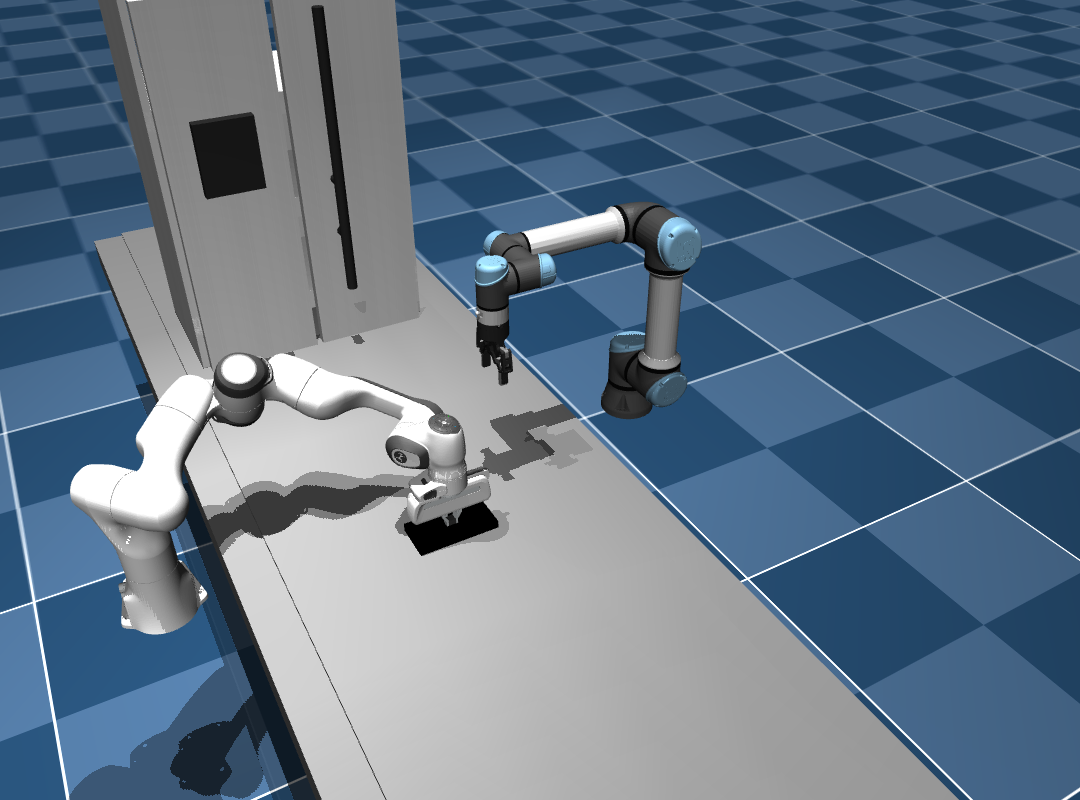

In [29]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory_keycard.position.clone()
    qpos = qpos[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

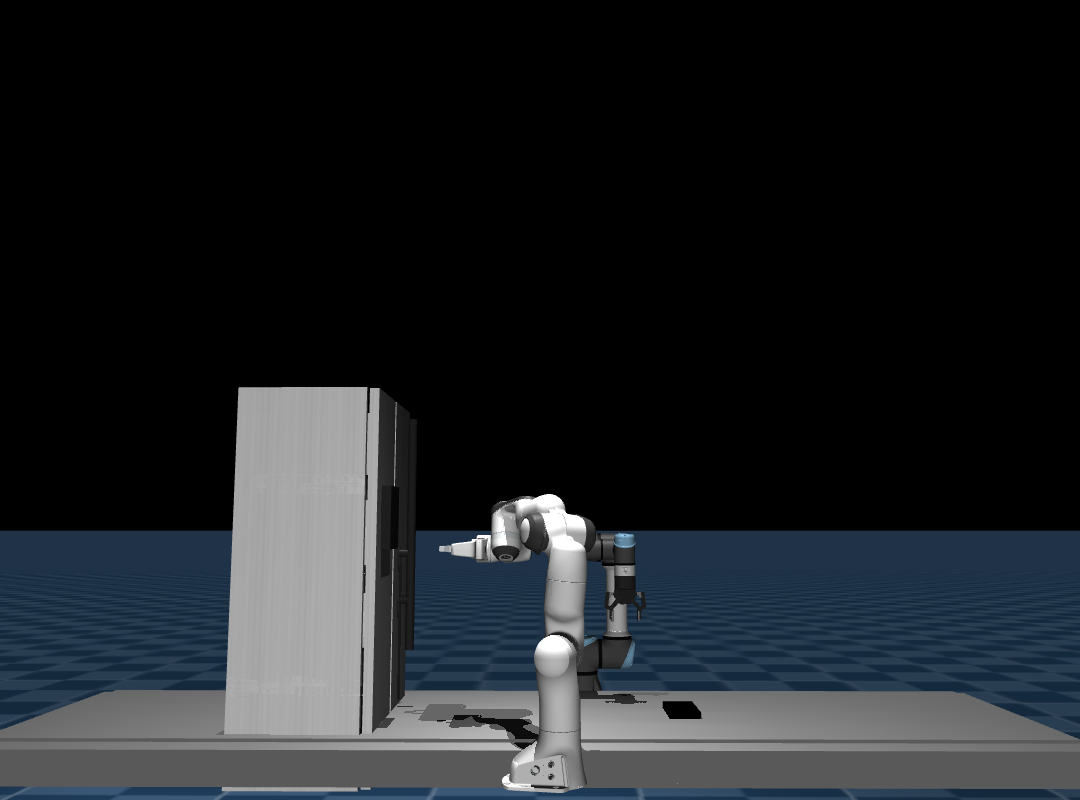

In [25]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory[-1].position.clone()
    qpos = qpos[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=1, width = 1080, height = 800))
img

In [32]:


# start_state = JointState.from_position(retract_cfg.view(1,-1)+0.1)
# start_state.velocity[:] = 0.0
# start_state.acceleration[:] = 0.0

# #First goal is keycard pos
# goal_pose1 = Pose.from_list(robot_keycard_pose, q_xyzw=False)
# goal_pose2 = Pose.from_list(robot_keyreader_pose, q_xyzw=False)

# # goal_pose1.position += torch.tensor([0., 0., 0.1]).cuda()
# print("Keycard Pose: ", goal_pose1)
# print("Keyreader Pose: ", goal_pose2)

#  #joint_names=["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5", "panda_joint6","panda_joint7"])
# # start_state = trajectory[-1].unsqueeze(0).clone()

# result1 = panda_motion_gen.plan_single(start_state.clone(), goal_pose1, MotionGenPlanConfig(parallel_finetune=True, max_attempts=1))
# print("Success:", result1.success)
# if result1.success.item():
#     panda_keycard_traj = result1.get_interpolated_plan().clone()


tensor([[ 0.0000],
        [-1.3000],
        [ 0.0000],
        [-2.5000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000]], device='cuda:0')
Keycard Pose:  Pose(position=tensor([[-0.1000,  0.6500,  0.1706]], device='cuda:0'), quaternion=tensor([[0., 1., 0., 0.]], device='cuda:0'), rotation=None, batch=1, n_goalset=1, name='ee_link', normalize_rotation=True)
Keyreader Pose:  Pose(position=tensor([[-0.8000,  0.5100,  0.7000]], device='cuda:0'), quaternion=tensor([[ 0.0000, -0.7071,  0.0000,  0.7071]], device='cuda:0'), rotation=None, batch=1, n_goalset=1, name='ee_link', normalize_rotation=True)
Success: tensor([True], device='cuda:0')


In [40]:
# #Second goal is keyreader_pose
# # goal_pose2 = Pose.from_list(robot_keyreader_pose)
# # print("Key reader Pose: ", goal_pose2)

# start_state = panda_keycard_traj[-1].unsqueeze(0).clone()

# result2 = panda_motion_gen.plan_single(start_state, goal_pose2, MotionGenPlanConfig(parallel_finetune=True, max_attempts=1))
# print("Success: ", result2.success)
# if result2.success.item():
#     panda_keyreader_traj = result2.get_interpolated_plan().clone()


Success:  tensor([False], device='cuda:0')


## Define Transformation of World Pos to Robot Frame to use Curobo

In [34]:
# # doorcabinet.physics.named.data.qpos
# panda_keycard_traj.position[-1]

tensor([-0.4126, -1.5729,  1.6836, -1.6667,  1.5772,  1.6662,  1.8324],
       device='cuda:0')

In [35]:
# panda2.joint_idxs_in_qpos
#Franka Indexes: (0, 3, 4, 5, 6, 7, 8, 9)
franka_mobile_idxs = [3, 4, 5, 6, 7, 8, 9, 0]
# franka_idxs = [3, 4, 5, 6, 7, 8, 9, 0]

panda_keycard_traj_list = panda_keycard_traj.position[-1].unsqueeze(0).clone()
panda_keycard_traj_list.tolist()[0] + [0.]
# panda2.joint_idxs_in_qpos

[-0.41262710094451904,
 -1.5729451179504395,
 1.683613896369934,
 -1.6666560173034668,
 1.5771775245666504,
 1.6662262678146362,
 1.8324272632598877,
 0.0]

In [36]:
# doorcabinet.physics.named.data.qpos

FieldIndexer(qpos):
 0                   keycard_joint [ 0.5     ]
 1                   keycard_joint [ 0.5     ]
 2                   keycard_joint [ 0.171   ]
 3                   keycard_joint [ 1       ]
 4                   keycard_joint [ 5.94e-18]
 5                   keycard_joint [ 1.54e-15]
 6                   keycard_joint [ 6.66e-20]
 7          cabinet/rightdoorhinge [ 0       ]
 8          ur5e/ur5e_0_base_joint [-4.85e-05]
 9  ur5e/ur5e_0_shoulder_pan_joint [-1.57    ]
10 ur5e/ur5e_0_shoulder_lift_joint [-1.57    ]
11         ur5e/ur5e_0_elbow_joint [ 1.57    ]
12       ur5e/ur5e_0_wrist_1_joint [-1.57    ]
13       ur5e/ur5e_0_wrist_2_joint [-1.57    ]
14       ur5e/ur5e_0_wrist_3_joint [ 2.48e-06]
15         ur5e/right_driver_joint [ 0.000113]
16        ur5e/right_coupler_joint [ 0.00463 ]
17    ur5e/right_spring_link_joint [ 0.00532 ]
18       ur5e/right_follower_joint [-0.0179  ]
19          ur5e/left_driver_joint [ 0.000104]
20         ur5e/left_coupler_joint [ 0.0

In [37]:
doorcabinet.physics.named.data.qpos[panda2.joint_idxs_in_qpos]

array([-4.76744986e-01, -1.58475641e+00,  1.89838324e+00, -1.59053410e+00,
        1.60065183e+00,  1.90285579e+00,  1.85560849e+00, -2.24479867e-05])

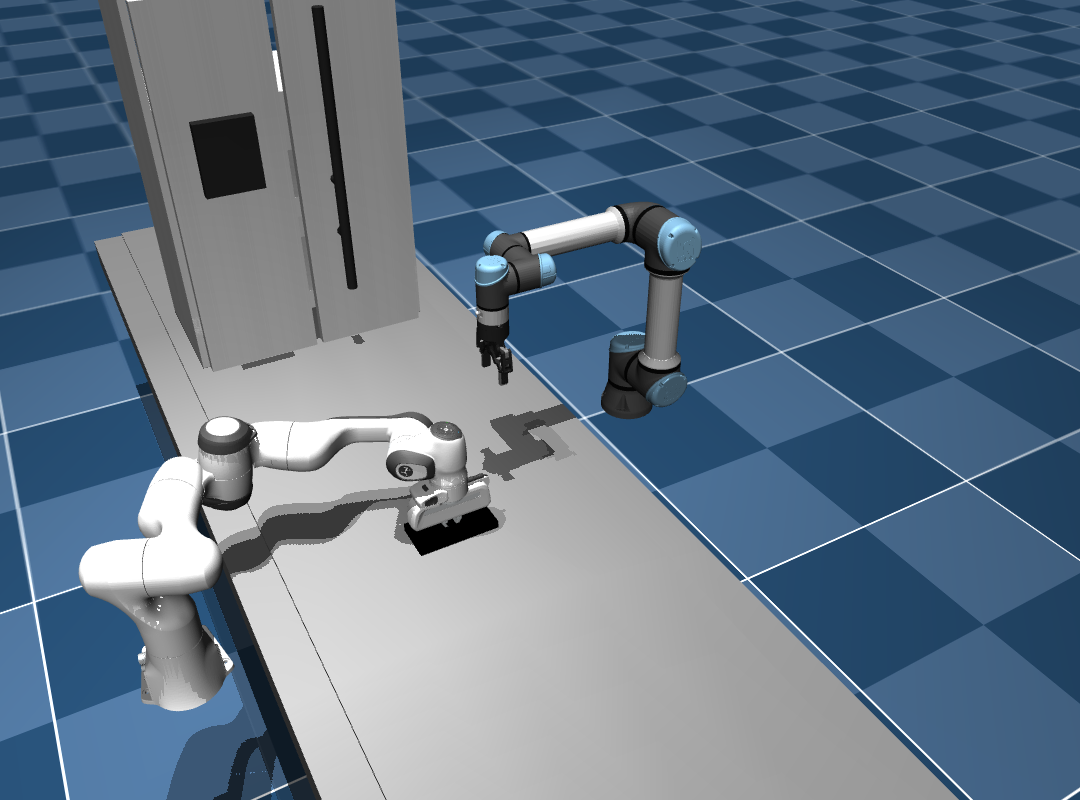

In [38]:
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = panda_keycard_traj_list.tolist()[0] + [0.] #[1.5,0.2239593029022217,0.09476885199546814,-2.3484880924224854,
                                                                #-0.3112894892692566,2.95723295211792, 1.0371127128601074,0.]#panda_keycard_traj_list
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

In [ ]:
#Try to move to open door pose
goal_pose = Pose.from_list([-0.2,  -0.4,  0.5, 0., -0.707,  0., 0.707])  # x, y, z, qw, qx, qy, qz
# goal_pose = Pose.from_list([0.5, 0., 0.5, 0.0, 1.0, 0.0, 0.0])  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    traj.position[-1].view(1, 6).cuda(),
    joint_names=['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
)

# ["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5",
#   "panda_joint6","panda_joint7"]
# ["base_x", "base_y", "base_z", "panda_joint1", "panda_joint2", "panda_joint3", "panda_joint4", "panda_joint5", "panda_joint6", "panda_joint7", ],

# print(goal_pose)

result = motion_gen.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=1))
print("Optimized:", result.optimized_dt)
print()
open_door_traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

In [ ]:
# traj.position.shape
paths = (traj.position).cpu().detach().numpy().copy()
paths = np.concatenate([paths, np.zeros((paths.shape[0], 1))], axis=1)
door_grasp_idx = len(paths) - 1

paths2 = panda_keycard_traj.position.cpu().detach().numpy().copy()
paths2 = np.concatenate([paths2, np.zeros((paths2.shape[0], 1))], axis=1)

# print(paths.shape)
paths3 = (open_door_traj.position).cpu().detach().numpy().copy()
paths3 = np.concatenate([paths2, np.zeros((paths2.shape[0], 1))], axis=1)

paths = np.concatenate([paths, paths2, paths3], axis=0)
# print(paths.shape)


In [ ]:
ur5e.joint_idxs_in_qpos, paths[-1]

with doorcabinet.physics.reset_context():
   q = doorcabinet.physics.data.qpos.copy()
   #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
   q[ur5e.joint_idxs_in_qpos] = paths[-1]
#    q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
   doorcabinet.physics.data.qpos = q
   doorcabinet.physics.step()
   img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

img

    

In [ ]:
doorcabinet.physics.named.data.ctrl

In [ ]:
### Once you get Trajectory of UR5e, add to paths to visualize entire task
frames = []
ctrls=[]
duration=10
framerate=60
control_rate=0.01

 # Reset state and time
doorcabinet.physics.reset()
#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)

# doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
# doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

while doorcabinet.physics.data.time < duration:
    t0 = doorcabinet.physics.data.time
    idx = int(doorcabinet.physics.data.time / control_rate)

    if idx >= len(paths):
        idx = len(paths) - 1
    
    # if idx >= key_grasp_idx:
    #     doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 10
    #     doorcabinet.physics.named.model.eq_active["keycard_panda"] = True


    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True

    # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

    # qpos = doorcabinet.physics.data.qpos.copy()
    # qpos[ur5e.joint_idxs_in_qpos] = paths[idx]
    # ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
    # ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)
    # doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]

    doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl] = paths[idx]

    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)
            frames.append(pixels)


In [ ]:
display_video(frames, framerate)

In [ ]:
# Third Party
import torch
# cuRobo
from curobo.types.base import TensorDeviceType
from curobo.wrap.model.robot_world import RobotWorld, RobotWorldConfig

robot_file = "franka.yml"

# create a world from a dictionary of objects
# cuboid: {} # dictionary of objects that are cuboids
# mesh: {} # dictionary of objects that are meshes
world_config = {
    "mesh": {
        "base_scene": {
            "pose": [10.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
            "file_path": "scene/nvblox/srl_ur10_bins.obj",
        },
    },
    "cuboid": {
        "table": {"dims": [2, 2, 0.2], "pose": [0.4, 0.0, -0.1, 1, 0, 0, 0]},
        "cube_1": {"dims": [0.1, 0.1, 0.2], "pose": [0.4, 0.0, 0.5, 1, 0, 0, 0]},
    },
    "mesh": {
        "scene": {
            "pose": [1.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
            "file_path": "scene/nvblox/srl_ur10_bins.obj",
        }
    },
}
tensor_args = TensorDeviceType()
config = RobotWorldConfig.load_from_config(robot_file, world_config,
                                          collision_activation_distance=0.0)
curobo_fn = RobotWorld(config)

In [ ]:
curobo_fn.kinematics.dof

In [ ]:
# create spheres with shape batch, horizon, n_spheres, 4.
q_sph = torch.randn((10, 1, 1, 4), device=tensor_args.device, dtype=tensor_args.dtype)
q_sph[...,3] = 0.2 # radius of spheres

d = curobo_fn.get_collision_distance(q_sph)

q_s = curobo_fn.sample(1, mask_valid=False)
print(q_s)


d_world, d_self = curobo_fn.get_world_self_collision_distance_from_joints(q_s)

state = curobo_fn.get_kinematics(q_s)

# d, d_world, d_self, state

In [ ]:
# cuRobo
from curobo.types.math import Pose
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

world_config = {
    "mesh": {
        "base_scene": {
            "pose": [10.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
            "file_path": "scene/nvblox/srl_ur10_bins.obj",
        },
    },
    "cuboid": {
        "table": {
            "dims": [2.0, 2.0, 0.2],  # x, y, z = [0.33, 0.2, 0.03]
            "pose": [0, 0, -0.1, 1, 0, 0, 0.0],  # x, y, z, qw, qx, qy, qz
        },
        "cabinet_right": {
            "dims": [0.01, 0.2, 0.6],
            "pose": [-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
        },
        "cabinet_left": {
            "dims": [0.01, 0.2, 0.6],
            "pose": [-0.7, 0.16, 0.47, 1, 0, 0, 0],
        },
        "cabinet_top": {
            "dims": [0.35, 0.2, 0.03],
            "pose": [-0.7, 0.5, 0.77, 1, 0, 0, 0],
        },
        "cabinet_bottom": {
            "dims": [0.35, 0.2, 0.03],
            "pose": [-0.7, 0.5, 0.17, 1, 0, 0, 0],
        },
        "cabinet_back": {
            "dims": [0.33, 0.015, 0.3],
            "pose": [-0.89, 0.5, 0.47, 1, 0, 0, 0],
        },
        "cabinet_panel": {
            "dims": [0.33, 0.2, 0.03],
            "pose": [-0.7, 0.5, 0.47, 1, 0, 0, 0],
        },
        "cabinet_leftdoor": {
            "dims": [0.16, 0.015, 0.6],
            "pose": [-0.48, 0.33, 0.47, 0, 1, 0, 0],
        }
    }
}

panda_flag = True

robot_file = "franka.yml" if panda_flag else "ur5e.yml" 

if panda_flag:
    start_pos = tensor_args.to_device([[0.0, -1.3, 0.0, -2.5, 0.0, 1.0, 0.0]])
    jointnames = ["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5", "panda_joint6","panda_joint7"] #,"panda_finger_joint1", "panda_finger_joint2"]
else:
    start_pos = torch.zeros(1, 6).cuda()
    jointnames = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']

motion_gen_config = MotionGenConfig.load_from_robot_config(
    robot_file,
    world_config,
    interpolation_dt=0.01,
)
motion_gen = MotionGen(motion_gen_config)
motion_gen.warmup()

# goal_pose = Pose(
#     position=tensor_args.to_device([[0.5, 0.0, 0.3]]),
#     quaternion=tensor_args.to_device([[1, 0, 0, 0]]),
# )

retract_cfg = motion_gen.get_retract_config()
# print(retract_cfg)

state = motion_gen.rollout_fn.compute_kinematics(
    JointState.from_position(retract_cfg.view(1, -1))
)

# [-0.4,  -0.6,  0.5, 0., -0.707,  0., 0.707]
# [-0.4, 0.0, 0.4, 1.0, 0.0, 0.0, 0.0]

# goal_pose = Pose.from_list(keycard_pose)  # x, y, z, qw, qx, qy, qz
goal_pose = Pose.from_list([0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 0.0])

start_state = JointState.from_position(
    start_pos,
    joint_names=jointnames
)

result = motion_gen.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=1))
print("Optimized:", result.optimized_dt)
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

## Getting Kinova Arm

In [ ]:
kinova_model = mjcf.from_path("rocobench/envs/assets/kinova_with_base/base_with_kinova_gripper.xml")
kinova_physics = mjcf.Physics.from_mjcf_model(kinova_model)

print(kinova_physics.named.data.ctrl)

In [ ]:
with kinova_physics.reset_context():
#    q = kinova_physics.data.qpos.copy()
    kinova_physics.data.ctrl = [1.5]*8
    kinova_physics.data.qpos = [0.1, 5.5, 0.5, 0.1, 0.3, 0.4, 0.6, 0.]
#    #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
#    q[ur5e.joint_idxs_in_qpos] = paths[-1]
# #    q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
#    doorcabinet.physics.data.qpos = q
    kinova_physics.step()
print(kinova_physics.named.data.ctrl)

img = PIL.Image.fromarray(kinova_physics.render(width = 640, height = 480))

img